In [1]:
from Dataset.dataset import Eve
import numpy as np
from sksurv.ensemble import RandomSurvivalForest
import pickle
from model import XSurvKMeansRF
import time

C:\Users\Abd\AppData\Local\conda\conda\envs\hh\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = Eve('Dataset/Eve_data.csv')

Dataset Description =======================
Dataset Name: Eve
Dataset Shape: (15699, 197)
Events: 17.79 %
NaN Values: 0.00 %
Events % in splits: 16.88, 18.85, 16.15, 17.55, 19.52, 



In [3]:
(x_train, ye_train, y_train, e_train,
 x_val, ye_val, y_val, e_val,
 x_test, ye_test, y_test, e_test) = ds.get_train_val_test_from_splits(test_id=0, val_id=1)
 #train_df_orig, val_df_orig, test_df_orig) = ds.get_train_val_test_from_splits(test_id=0, val_id=1)

print('Testing on %d-----------------------------' % 1)
print(x_train.shape, x_val.shape)

Testing on 1-----------------------------
(9420, 195) (3140, 195)


In [4]:
# special for RSF
dt = np.dtype('bool,float')
y_train_surv = np.array([(bool(e), y) for e, y in zip(e_train, y_train)], dtype=dt)
y_val_surv = np.array([(bool(e), y) for e, y in zip(e_val, y_val)], dtype=dt)
print(y_train_surv.shape, y_val_surv.shape)

# train RSF
rsf = RandomSurvivalForest(n_estimators=50,
                           min_samples_split=20,
                           min_samples_leaf=10,
                           max_features="sqrt",
                           oob_score=True,
                           n_jobs=-1,
                           random_state=20)
rsf.fit(x_train, y_train_surv)

(9420,) (3140,)


RandomSurvivalForest(max_features='sqrt', min_samples_leaf=10,
                     min_samples_split=20, n_estimators=50, n_jobs=-1,
                     oob_score=True, random_state=20)

In [5]:
#pickle.dump(rsf, open('rsf_model_eve.mdl', 'wb'))
#rsf = pickle.load(open('rsf_model_eve.mdl', 'rb'))

In [6]:
cindex_train = rsf.score(x_train, y_train_surv)
cindex_oob = rsf.oob_score_
cindex_val = rsf.score(x_val, y_val_surv)
cindex_val_events = rsf.score(x_val[e_val==1], y_val_surv[e_val==1])

print('Train cindex {:.2f}'.format(cindex_train*100))
print('Test cindex {:.2f}'.format(cindex_val*100))
print('Test cindex Events Only {:.2f}'.format(cindex_val_events*100))

Train cindex 88.85
Test cindex 82.40
Test cindex Events Only 56.93


In [7]:
surv_train = rsf.predict_survival_function(x_train, return_array=True)
surv_val = rsf.predict_survival_function(x_val, return_array=True)
surv_test = rsf.predict_survival_function(x_test, return_array=True)



#Explanation
xte_data = (x_train, y_train, e_train,
            x_val, y_val, e_val,
            x_test, y_test, e_test)

survival_curves = (surv_train, surv_val, surv_test)

shape: 1047


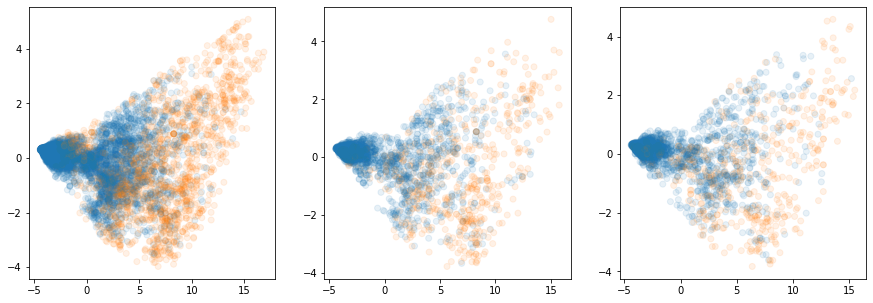

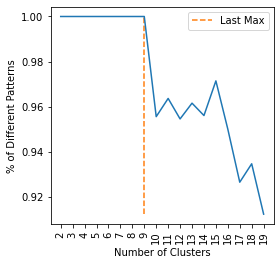

<Figure size 360x360 with 0 Axes>

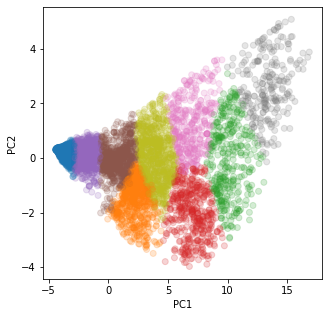

<Figure size 360x360 with 0 Axes>

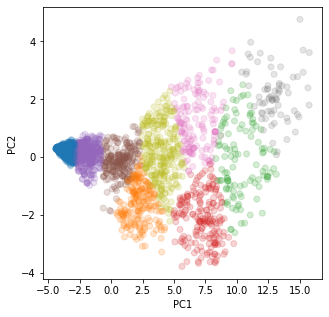

<Figure size 360x360 with 0 Axes>

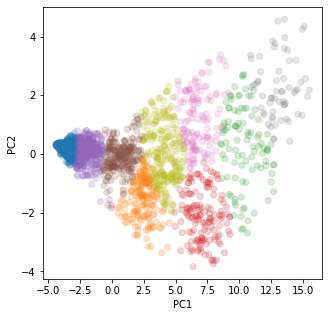

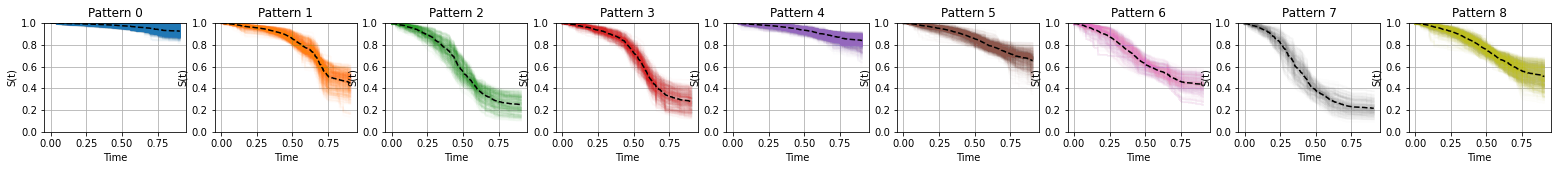

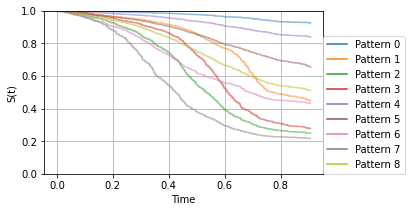

In [8]:
explainer = XSurvKMeansRF(prefix_name='eve_1', max_k=20, z_explained_variance_ratio_threshold=0.99, curves_diff_significance_level=0.05, max_depth=20)
explainer.fit(xte_data=xte_data, survival_curves=survival_curves, event_times=rsf.event_times_)#, pretrained_clustering_model="clustering_model_eve_9_20220223-152051.mdl", k=9)

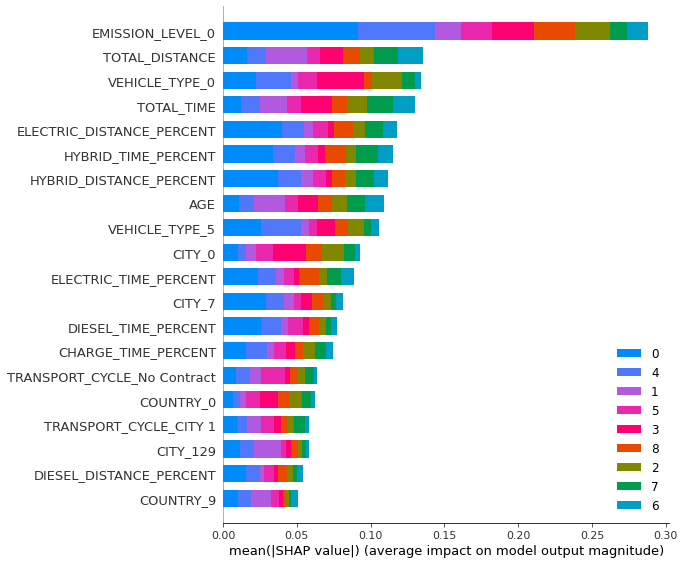

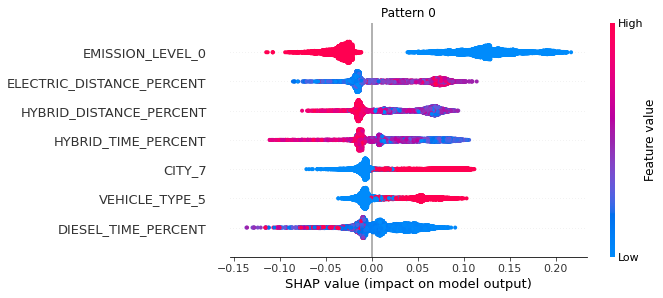

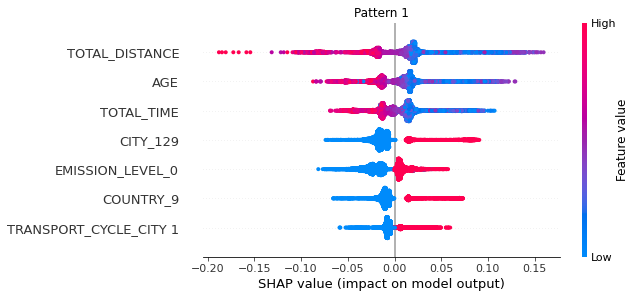

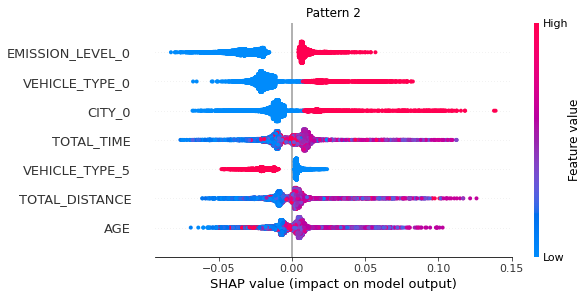

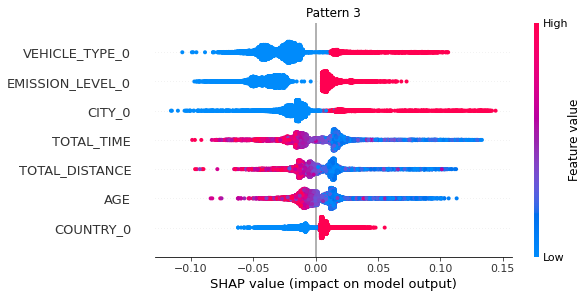

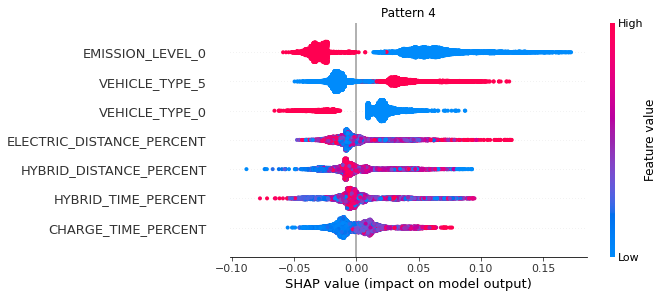

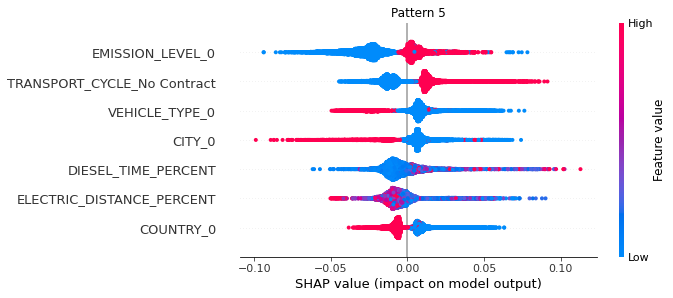

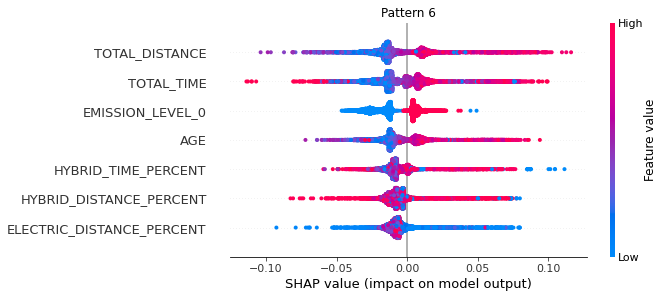

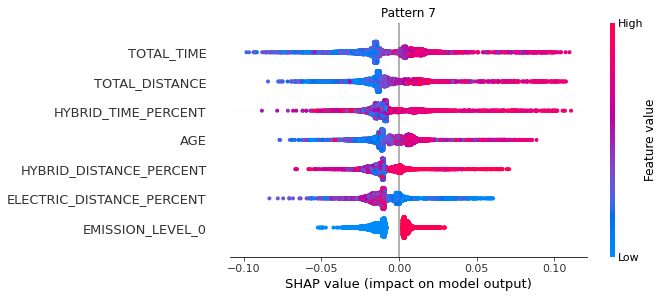

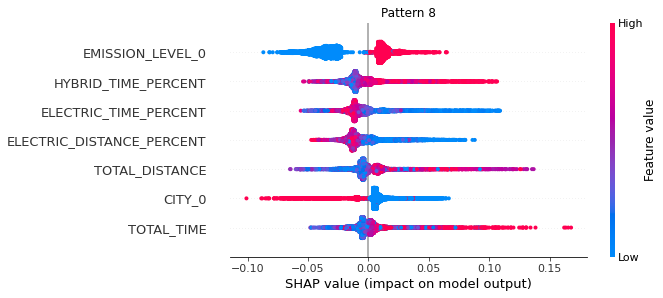

In [9]:
shap_values_train = explainer.explain(x=x_train, features_names_list=ds.features_names, suffex='train', max_display_subgroups=7)

In [10]:
#shap_values_val = explainer.explain(x=x_val, features_names_list=ds.features_names, suffex='val')

In [11]:
#shap_values_test = explainer.explain(x=x_test, features_names_list=ds.features_names, suffex='test')